# DCNN Model for Multi-label Bird Classification

## Setup

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import zipfile
import csv
import os
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/MyDrive/CSC413_Project/MFCC_augmented_last_train_val_split.zip"

Streaming output truncated to the last 5000 lines.
 extracting: train/Golden-crowned Sparrow_159724_seg_63.wav+Pine Siskin_159086_seg_2.wav.png  
 extracting: train/Song Sparrow_159078_seg_18.wav+Bewick's Wren_216178_seg_5.wav.png  
 extracting: train/Spotted Towhee_159542_seg_34.wav+Red-breasted Nuthatch_159321_seg_22.wav.png  
 extracting: train/Red-breasted Nuthatch_210121_seg_68.wav+Golden-crowned Sparrow_185189_seg_0.wav.png  
 extracting: train/Bewick's Wren_159989_seg_30.wav+Anna's Hummingbird_158912_seg_9.wav.png  
 extracting: train/Anna's Hummingbird_159808_seg_25.wav+Golden-crowned Sparrow_159656_seg_3.wav.png  
 extracting: train/Marsh Wren_158972_seg_7.wav+Song Sparrow_159000_seg_6.wav.png  
 extracting: train/Bewick's Wren_159989_seg_21.wav+Red-winged Blackbird_161635_seg_15.wav.png  
 extracting: train/Red-breasted Nuthatch_159321_seg_85.wav+White-crowned Sparrow_66173_seg_0.wav.png  
 extracting: train/Golden-crowned Sparrow_159724_seg_76.wav+White-crowned Sparrow_16020

In [ ]:
# Further split data into a training and validation set

def split_data_into_train_val(data_dir, zip_path, test_size=0.2, random_state=42):
    # Read the CSV to get file names and labels
    csv_file = os.path.join(data_dir, f'{data_dir.split("/")[-1]}.csv')
    df = pd.read_csv(csv_file)
    img_files = [os.path.join(data_dir, fname) for fname in df['filename']]
    label_str = label_str = ['_'.join(label) for label in zip(df['label1'], df['label2'])]

    # Perform the split
    train_files, val_files, train_labels, val_labels = train_test_split(
        img_files, label_str, test_size=test_size, stratify=label_str, random_state=random_state
    )

    with zipfile.ZipFile(zip_path, 'w') as z:

        # Function to add files and labels to the zip under a specific directory
        def add_to_zip(file_list, label_list, directory_name):
            labels_csv_path = os.path.join(directory_name, f'{directory_name}.csv')

            with open('temp_labels.csv', 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['filename', 'label1', 'label2'])

                for filepath, label in zip(file_list, label_list):
                    filename = os.path.basename(filepath)
                    arcname = os.path.join(directory_name, filename)
                    z.write(filepath, arcname=arcname)

                    writer.writerow([filename, label.split("_")[0], label.split("_")[1]])

            z.write('temp_labels.csv', arcname=labels_csv_path)
            os.remove('temp_labels.csv')

        # Add train and test datasets to the zip file
        add_to_zip(train_files, train_labels, 'train')
        add_to_zip(val_files, val_labels, 'val')

data_dir = '/content/train'
zip_path = '/content/drive/MyDrive/CSC413_Project/MFCC_augmented_last_train_val_split.zip'
split_data_into_train_val(data_dir, zip_path)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Preprocessing

In [4]:
class BirdDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.csv_file = f'{data_dir}/{data_dir.split("/")[-1]}.csv'
        self.transform = transform
        self.img_labels, self.label_map = self._get_image_labels_and_map()

    def _get_image_labels_and_map(self):
        # Load CSV file
        df = pd.read_csv(self.csv_file)

        # Extract filenames and bird names
        img_labels = list(zip(df['filename'], zip(df['label1'], df['label2'])))

        # Create a set of unique bird names
        label_set = set(df['label1']).union(set(df['label2']))

        # Create a map of bird names to indices
        label_map = {label: idx for idx, label in enumerate(sorted(label_set))}
        print(label_map)

        # Convert labels to one-hot encoding
        one_hot_encoded_labels = []
        for _, labels in img_labels:
            one_hot = torch.zeros(len(label_map))
            one_hot[label_map[labels[0]]] = 1
            one_hot[label_map[labels[1]]] = 1
            one_hot_encoded_labels.append((_, one_hot))

        return one_hot_encoded_labels, label_map

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name, one_hot_labels = self.img_labels[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, one_hot_labels

In [5]:
# Load and transform the dataset
def load_data(data_dir, batch_size, transform):
    dataset = BirdDataset(data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [6]:
# Define a transformation sequence
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


## Data for Training and Validation

In [ ]:
# Load data
train_data_dir = '/content/train'  # Update this path according to your data location
val_data_dir = '/content/val'
batch_size = 32
dataloaders = {
    'train': load_data(train_data_dir, batch_size, transform),
    'val': load_data(val_data_dir, batch_size, transform),
}

{"Anna's Hummingbird": 0, "Bewick's Wren": 1, 'Golden-crowned Sparrow': 2, 'Marsh Wren': 3, 'Pine Siskin': 4, 'Red-breasted Nuthatch': 5, 'Red-winged Blackbird': 6, 'Song Sparrow': 7, 'Spotted Towhee': 8, 'White-crowned Sparrow': 9}
{"Anna's Hummingbird": 0, "Bewick's Wren": 1, 'Golden-crowned Sparrow': 2, 'Marsh Wren': 3, 'Pine Siskin': 4, 'Red-breasted Nuthatch': 5, 'Red-winged Blackbird': 6, 'Song Sparrow': 7, 'Spotted Towhee': 8, 'White-crowned Sparrow': 9}


Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32, 10])


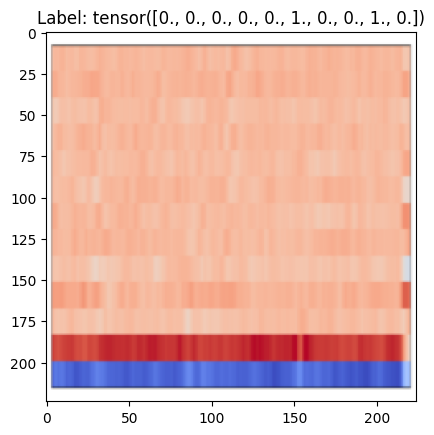

In [ ]:
# Example data visualization
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

print(f'Batch shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

plt.imshow(images[0].permute(1, 2, 0))
plt.title(f'Label: {labels[0]}')
plt.show()

## Model Training and Validation

In [ ]:
class MultiLabelResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        original_model = models.resnet18(pretrained=True)
        for param in original_model.parameters():
            param.requires_grad = False
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.classifier = nn.Linear(original_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) # return raw logits
        return x

In [ ]:
# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):

    model.to(device)
    best_f1 = 0.0
    best_auc = 0.0
    train_losses, val_losses, f1_scores, auc_scores = [], [], [], []

    for epoch in range(num_epochs):

        # Training Phase
        model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        train_losses.append(epoch_loss)

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        all_targets, all_predictions, all_probs = [], [], []
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                predicted_probs = torch.sigmoid(outputs)
                predicted_labels = (predicted_probs > 0.5).int()
                all_targets.append(labels.cpu().numpy())
                all_predictions.append(predicted_labels.cpu().numpy())
                all_probs.append(predicted_probs.cpu().numpy())

        val_loss = val_running_loss / len(dataloaders['val'].dataset)
        val_losses.append(val_loss)

        # Convert list of arrays to a single numpy array
        all_targets = np.vstack(all_targets)
        all_predictions = np.vstack(all_predictions)
        all_probs = np.vstack(all_probs)

        # Calculate F1-score and AUC
        epoch_f1 = f1_score(all_targets, all_predictions, average='macro')
        epoch_auc = roc_auc_score(all_targets, all_probs, average='macro')
        f1_scores.append(epoch_f1)
        auc_scores.append(epoch_auc)

        # Checkpoint best model
        if epoch_auc > best_auc:
            best_auc = epoch_auc
            torch.save(model, '/content/drive/MyDrive/best_model_auc.pt')
            print(f"Saved better model with AUC: {best_auc:.4f}")
        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            torch.save(model, '/content/drive/MyDrive/best_model_f1.pt')
            print(f"Saved better model with F1-score: {best_f1:.4f}")

        # Print epoch statistics
        print(f'Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, F1 Score: {epoch_f1:.4f}, AUC: {epoch_auc:.4f}')

    plot_training(train_losses, val_losses, f1_scores, auc_scores)


In [ ]:
def plot_training(train_losses, val_losses, f1_scores, auc_scores):
    # Plotting
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(f1_scores, label='F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(auc_scores, label='AUC Score')
    plt.title('AUC Score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize model, loss function, and optimizer
model = MultiLabelResNet(num_classes=10)  # Change `num_classes` based on your dataset
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 28.0MB/s]


In [ ]:
# Train model
train_model(model, dataloaders, criterion, optimizer, num_epochs=20)

Saved better model with AUC: 0.7808
Saved better model with F1-score: 0.3775
Epoch 1: Train Loss: 0.4710, Val Loss: 0.4830, F1 Score: 0.3775, AUC: 0.7808
Saved better model with AUC: 0.7863
Saved better model with F1-score: 0.4240
Epoch 2: Train Loss: 0.4395, Val Loss: 0.4501, F1 Score: 0.4240, AUC: 0.7863
Saved better model with AUC: 0.7878
Saved better model with F1-score: 0.4445
Epoch 3: Train Loss: 0.4437, Val Loss: 0.4157, F1 Score: 0.4445, AUC: 0.7878
Saved better model with AUC: 0.7948
Epoch 4: Train Loss: 0.4345, Val Loss: 0.4601, F1 Score: 0.4068, AUC: 0.7948
Epoch 5: Train Loss: 0.4290, Val Loss: 0.4387, F1 Score: 0.3892, AUC: 0.7921
Epoch 6: Train Loss: 0.4258, Val Loss: 0.4409, F1 Score: 0.4324, AUC: 0.7935
Epoch 7: Train Loss: 0.4317, Val Loss: 0.4904, F1 Score: 0.4182, AUC: 0.7939
Epoch 8: Train Loss: 0.4341, Val Loss: 0.4610, F1 Score: 0.4000, AUC: 0.7924
Saved better model with AUC: 0.7951
Epoch 9: Train Loss: 0.4256, Val Loss: 0.4539, F1 Score: 0.4238, AUC: 0.7951
Save

NameError: name 'plt' is not defined

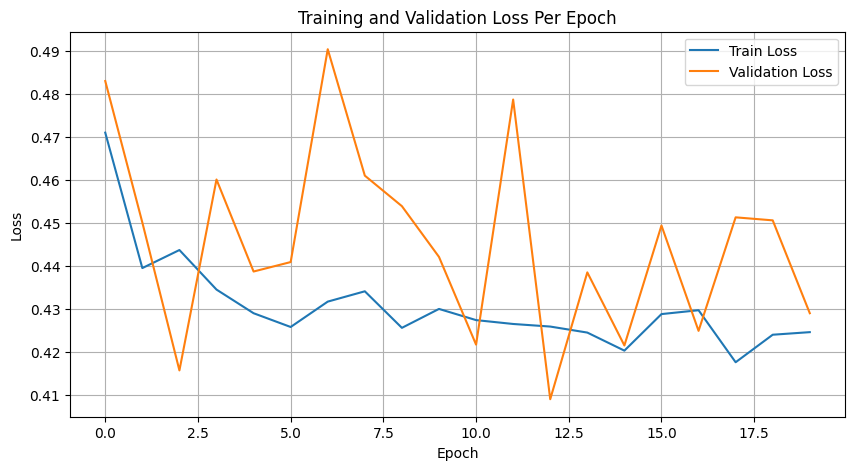

In [ ]:
# Plotting because intial plot failed due to matplotlib pyplot not imported

output_text = """
Saved better model with AUC: 0.7808
Saved better model with F1-score: 0.3775
Epoch 1: Train Loss: 0.4710, Val Loss: 0.4830, F1 Score: 0.3775, AUC: 0.7808
Saved better model with AUC: 0.7863
Saved better model with F1-score: 0.4240
Epoch 2: Train Loss: 0.4395, Val Loss: 0.4501, F1 Score: 0.4240, AUC: 0.7863
Saved better model with AUC: 0.7878
Saved better model with F1-score: 0.4445
Epoch 3: Train Loss: 0.4437, Val Loss: 0.4157, F1 Score: 0.4445, AUC: 0.7878
Saved better model with AUC: 0.7948
Epoch 4: Train Loss: 0.4345, Val Loss: 0.4601, F1 Score: 0.4068, AUC: 0.7948
Epoch 5: Train Loss: 0.4290, Val Loss: 0.4387, F1 Score: 0.3892, AUC: 0.7921
Epoch 6: Train Loss: 0.4258, Val Loss: 0.4409, F1 Score: 0.4324, AUC: 0.7935
Epoch 7: Train Loss: 0.4317, Val Loss: 0.4904, F1 Score: 0.4182, AUC: 0.7939
Epoch 8: Train Loss: 0.4341, Val Loss: 0.4610, F1 Score: 0.4000, AUC: 0.7924
Saved better model with AUC: 0.7951
Epoch 9: Train Loss: 0.4256, Val Loss: 0.4539, F1 Score: 0.4238, AUC: 0.7951
Saved better model with AUC: 0.7955
Epoch 10: Train Loss: 0.4300, Val Loss: 0.4421, F1 Score: 0.4148, AUC: 0.7955
Saved better model with F1-score: 0.4484
Epoch 11: Train Loss: 0.4274, Val Loss: 0.4217, F1 Score: 0.4484, AUC: 0.7949
Epoch 12: Train Loss: 0.4265, Val Loss: 0.4787, F1 Score: 0.3991, AUC: 0.7924
Saved better model with F1-score: 0.4819
Epoch 13: Train Loss: 0.4259, Val Loss: 0.4090, F1 Score: 0.4819, AUC: 0.7934
Epoch 14: Train Loss: 0.4245, Val Loss: 0.4385, F1 Score: 0.4420, AUC: 0.7939
Epoch 15: Train Loss: 0.4203, Val Loss: 0.4215, F1 Score: 0.4635, AUC: 0.7946
Epoch 16: Train Loss: 0.4288, Val Loss: 0.4494, F1 Score: 0.4398, AUC: 0.7935
Epoch 17: Train Loss: 0.4297, Val Loss: 0.4249, F1 Score: 0.4575, AUC: 0.7948
Saved better model with AUC: 0.7966
Epoch 18: Train Loss: 0.4176, Val Loss: 0.4513, F1 Score: 0.4377, AUC: 0.7966
Epoch 19: Train Loss: 0.4240, Val Loss: 0.4506, F1 Score: 0.4384, AUC: 0.7950
Epoch 20: Train Loss: 0.4246, Val Loss: 0.4290, F1 Score: 0.4336, AUC: 0.7936
"""

# Extract train and validation loss
train_losses = []
val_losses = []
for line in output_text.split('\n'):
    match = re.search(r"Epoch \d+: Train Loss: ([\d\.]+), Val Loss: ([\d\.]+)", line)
    if match:
        train_losses.append(float(match.group(1)))
        val_losses.append(float(match.group(2)))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(model, '/content/drive/MyDrive/dcnn_last_model.pt')

## Test Evaluation

In [16]:
def evaluate_model(model, dataloader, num_classes):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device
    all_preds, all_labels = [], []

    # Inference
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            predicted_probs = torch.sigmoid(outputs)
            predicted_labels = (predicted_probs > 0.5).float()
            all_preds.extend(predicted_labels.numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Calculate F1 scores
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    print(f'Macro F1 Score: {macro_f1:.4f}')
    print(f'Micro F1 Score: {micro_f1:.4f}')

    # Calculate Precision scores
    macro_precision = precision_score(all_labels, all_preds, average='macro')
    micro_precision = precision_score(all_labels, all_preds, average='micro')
    print(f'Macro Precision Score: {macro_precision:.4f}')
    print(f'Micro Precision Score: {micro_precision:.4f}')

    # Calculate Recall scores
    macro_recall = recall_score(all_labels, all_preds, average='macro')
    micro_recall = recall_score(all_labels, all_preds, average='micro')
    print(f'Macro Recall Score: {macro_recall:.4f}')
    print(f'Micro Recall Score: {micro_recall:.4f}')

    # Calculate AUC for each class and mean AUC
    auc_scores = roc_auc_score(all_labels, all_preds, average=None)
    macro_auc = roc_auc_score(all_labels, all_preds, average='macro')
    micro_auc = roc_auc_score(all_labels, all_preds, average='micro')
    print(f'Macro AUC Score: {macro_auc:.4f}')
    print(f'Micro AUC Score: {micro_auc:.4f}')
    print('AUC by class:', auc_scores)

    # Print in latex table format
    print("===== Results =====")
    print(f'{micro_precision:.4f} & {macro_precision:.4f} & {micro_recall:.4f} & \
        {macro_recall:.4f} & {micro_f1:.4f} & {macro_f1:.4f} & {micro_auc:.4f} & {macro_auc:.4f}')
    print("===================")

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(num_classes)]))

    # Confusion Matrix for each class
    for i in range(num_classes):
        cm = confusion_matrix([label[i] for label in all_labels], [pred[i] for pred in all_preds])
        print(f'Confusion Matrix for Class {i}:\n', cm)

In [ ]:
!unzip "/content/drive/MyDrive/CSC413_Project/MFCC_augmented_last_split.zip"

In [17]:
model_best_auc = torch.load('/content/drive/MyDrive/best_model_auc.pt')
test_data_dir = '/content/test'
test_dataloader = load_data(test_data_dir, 1, transform)
evaluate_model(model_best_auc, test_dataloader, 10)

{"Anna's Hummingbird": 0, "Bewick's Wren": 1, 'Golden-crowned Sparrow': 2, 'Marsh Wren': 3, 'Pine Siskin': 4, 'Red-breasted Nuthatch': 5, 'Red-winged Blackbird': 6, 'Song Sparrow': 7, 'Spotted Towhee': 8, 'White-crowned Sparrow': 9}
Macro F1 Score: 0.4422
Micro F1 Score: 0.4970
Macro Precision Score: 0.6560
Micro Precision Score: 0.5674
Macro Recall Score: 0.4218
Micro Recall Score: 0.4421
Macro AUC Score: 0.6677
Micro AUC Score: 0.6789
AUC by class: [0.76021398 0.60708351 0.50592502 0.77507658 0.6782336  0.79912675
 0.6386827  0.57373767 0.69450451 0.64414896]
===== Results =====
0.5674 & 0.6560 & 0.4421 &         0.4218 & 0.4970 & 0.4422 & 0.6789 & 0.6677
              precision    recall  f1-score   support

     Class 0       0.68      0.59      0.63       892
     Class 1       0.68      0.26      0.37      1182
     Class 2       0.90      0.01      0.02       743
     Class 3       0.57      0.65      0.61       779
     Class 4       0.82      0.37      0.51       814
     Clas

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


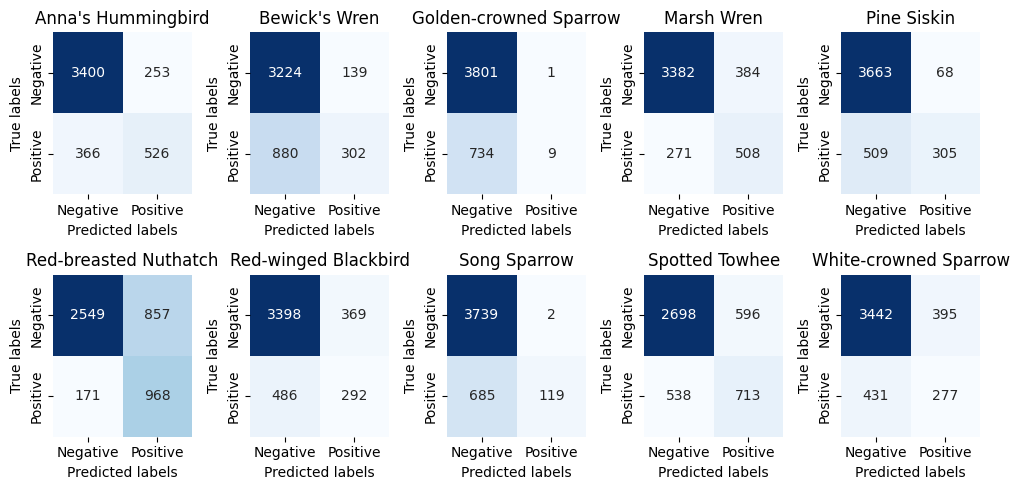

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CONFUSION MATRIX VISUALIZATION
# Define the labels and the confusion matrices
labels = {
    "Anna's Hummingbird": [[3400, 253], [366, 526]],
    "Bewick's Wren": [[3224, 139], [880, 302]],
    'Golden-crowned Sparrow': [[3801, 1], [734, 9]],
    'Marsh Wren': [[3382, 384], [271, 508]],
    'Pine Siskin': [[3663, 68], [509, 305]],
    'Red-breasted Nuthatch': [[2549, 857], [171, 968]],
    'Red-winged Blackbird': [[3398, 369], [486, 292]],
    'Song Sparrow': [[3739, 2], [685, 119]],
    'Spotted Towhee': [[2698, 596], [538, 713]],
    'White-crowned Sparrow': [[3442, 395], [431, 277]]
}

# Setting up the figure and axes again for confusion matrices
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()  # Flatten the grid into a list for easier access

# Plot each confusion matrix again
for i, (bird, matrix) in enumerate(labels.items()):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axs[i], cbar=False)
    axs[i].set_title(f'{bird}')
    axs[i].set_xlabel('Predicted labels')
    axs[i].set_ylabel('True labels')
    axs[i].set_xticklabels(['Negative', 'Positive'])
    axs[i].set_yticklabels(['Negative', 'Positive'])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('/content/dcnn_cm.pdf', format='pdf', dpi=600)
plt.show()
